In [26]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [88]:
words = open("names.txt").read().splitlines()

a = ord("a")
alps = ["."] + [chr(idx) for idx in range(a, a+26)]

stoi = {s:i for i, s in enumerate(alps)}
itos = {i:s for s, i in stoi.items()}

In [89]:
block_size = 3

def build_dataset(words):
    X = []
    Y = []
    for word in words:
        context = [0] * block_size
        for ch in list(word) + ["."]:
            label_idx = stoi[ch]
            X.append(context)
            Y.append(label_idx)
            context = context[1:] + [label_idx]
    return torch.tensor(X), torch.tensor(Y)

N = len(words)
random.seed(42)
random.shuffle(words)

tr_idx = int(N * 0.8)
dev_idx = tr_idx + int(N * 0.1)

Xtr, Ytr = build_dataset(words[:tr_idx])
Xdev, Ydev = build_dataset(words[tr_idx:dev_idx])
Xte, Yte = build_dataset(words[dev_idx:])

In [ ]:
class Net:
    def __init__(self, emb_size, hidden_size, block_size=3):
        self.emb_size = emb_size
        self.block_size = block_size
        
        g = torch.Generator().manual_seed(2147483647)
        self.C = torch.randn((27, emb_size), generator=g)
        self.W1 = torch.randn((emb_size * block_size, hidden_size), generator=g)
        self.b1 = torch.randn(hidden_size, generator=g)
        self.W2 = torch.randn((hidden_size, 27), generator=g)
        self.b2 = torch.randn(27, generator=g)
     
            
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad = True
        
    def forward(self, X, Y=None, alpha=0):
        emb = self.C[X]
        h = torch.tanh(emb.view(-1, self.emb_size * self.block_size) @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        if Y is not None:
            self.loss = F.cross_entropy(logits, Y) + alpha * ((self.W1**2).mean() + (self.W2**2).mean())
        else:
            self.loss = None
        return logits, self.loss
    
    def backward(self):
        for p in self.parameters:
            p.grad = None
        self.loss.backward()
        
    def update(self, lr):
        for p in self.parameters:
            p.data += -lr * p.grad
            

In [140]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

bs = 32
total_iter = 1000 

steps = []
losses = []

net = Net(emb_size=2, hidden_size=100, block_size=3)

for itr in range(total_iter):
    batch_ix = torch.randint(low=0, high=Xtr.shape[0], size=(bs,))
    
    _, loss = net.forward(Xtr[batch_ix], Ytr[batch_ix])
    net.backward()
    net.update(lrs[itr])
        
    steps.append(itr)
    losses.append(loss.item())

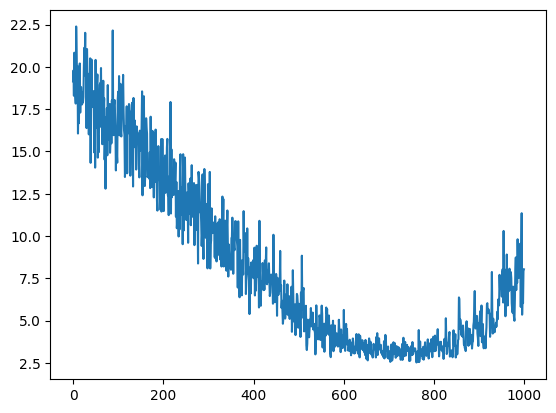

In [141]:
plt.plot(steps, losses) # lrs[700] = tensor(0.1265) seems like a proper lr

In [143]:
bs = 32
total_iter = 30000

steps = []
losses = []

net = Net(emb_size=2, hidden_size=100, block_size=3)

for itr in range(total_iter):
    batch_ix = torch.randint(low=0, high=Xtr.shape[0], size=(bs,))
    
    _, loss = net.forward(Xtr[batch_ix], Ytr[batch_ix])
    # if itr % 1000 == 0:
    #     print(loss)
    net.backward()
    lr = 0.1 if total_iter < 20000 else 0.01
    net.update(lr)
        
    steps.append(itr)
    losses.append(loss.item())

with torch.no_grad():
    _, train_loss = net.forward(Xtr, Ytr)
    _, dev_loss = net.forward(Xdev, Ydev)
    print(train_loss) # train loss
    print(dev_loss) # dev loss

tensor(2.4781)
tensor(2.4736)


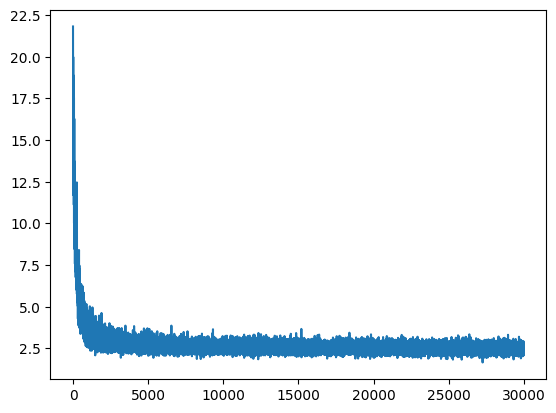

In [144]:
plt.plot(steps, losses)

In [145]:
bs = 32
total_iter = 300000

steps = []
losses = []

net = Net(emb_size=10, hidden_size=200, block_size=3)

for itr in range(total_iter):
    batch_ix = torch.randint(low=0, high=Xtr.shape[0], size=(bs,))
    
    _, loss = net.forward(Xtr[batch_ix], Ytr[batch_ix])
    # if itr % 1000 == 0:
    #     print(loss)
    net.backward()
    lr = 0.1 if total_iter < 20000 else 0.01
    net.update(lr)
        
    steps.append(itr)
    losses.append(loss.item())
    
with torch.no_grad():
    _, train_loss = net.forward(Xtr, Ytr)
    _, dev_loss = net.forward(Xdev, Ydev)
    print(train_loss.item()) # train loss
    print(dev_loss.item()) # dev loss

2.24131178855896
2.2556114196777344


### E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2

In [152]:
# increased emb_size

bs = 32
total_iter = 350000

steps = []
losses = []

net = Net(emb_size=16, hidden_size=200, block_size=3)

for itr in range(total_iter):
    batch_ix = torch.randint(low=0, high=Xtr.shape[0], size=(bs,))
    
    _, loss = net.forward(Xtr[batch_ix], Ytr[batch_ix])
    net.backward()
    lr = 0.1 if total_iter < 200000 else 0.01
        
    net.update(lr)
        
    steps.append(itr)
    losses.append(loss.item())
    
with torch.no_grad():
    _, train_loss = net.forward(Xtr, Ytr)
    _, dev_loss = net.forward(Xdev, Ydev)
    print(train_loss.item()) # train loss
    print(dev_loss.item()) # dev loss

2.171165704727173
2.2135086059570312


In [156]:
block_size = 3
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    context = [0] * block_size
    output = []
    while True:
        X = torch.tensor([context])
        logits, _ = net.forward(X)
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        
        next_chr = itos[idx]
        output.append(next_chr)
        context = context[1:] + [idx]
        
        if idx == 0:
            break
    print("".join(output))

carmah.
amelia.
khi.
mri.
reh.
cassanden.
jazonen.
deliah.
jareei.
ner.
kiah.
maiiv.
kaleigh.
ham.
jorn.
quintis.
lilea.
jadia.
watthoniearynix.
kaeliilsa.


### E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

In [125]:
uniform_loss = -torch.log(torch.tensor(1/27))
print(uniform_loss)

tensor(3.2958)


In [165]:
class Net:
    def __init__(self, emb_size, hidden_size, block_size=3):
        self.emb_size = emb_size
        self.block_size = block_size
        
        g = torch.Generator().manual_seed(2147483647)
        self.C = torch.randn((27, emb_size), generator=g)
        self.W1 = torch.randn((emb_size * block_size, hidden_size), generator=g) * 0.1
        self.b1 = torch.randn(hidden_size, generator=g) * 0 # TODO: why is it okay for the bias to be set to 0 but not the weight
        self.W2 = torch.randn((hidden_size, 27), generator=g) * 0.1
        self.b2 = torch.randn(27, generator=g) * 0
     
            
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad = True
        
    def forward(self, X, Y=None, alpha=0):
        emb = self.C[X]
        h = torch.tanh(emb.view(-1, self.emb_size * self.block_size) @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        if Y is not None:
            self.loss = F.cross_entropy(logits, Y) + alpha * ((self.W1**2).mean() + (self.W2**2).mean())
        else:
            self.loss = None
        return logits, self.loss
    
    def backward(self):
        for p in self.parameters:
            p.grad = None
        self.loss.backward()
        
    def update(self, lr):
        for p in self.parameters:
            p.data += -lr * p.grad

In [163]:
net = Net(emb_size=16, hidden_size=200, block_size=3)
with torch.no_grad():
    print(net.forward(Xtr, Ytr)[1])

tensor(3.4708)


In [170]:
bs = 32
total_iter = 350000

steps = []
losses = []

net = Net(emb_size=16, hidden_size=200, block_size=3)

for itr in range(total_iter):
    batch_ix = torch.randint(low=0, high=Xtr.shape[0], size=(bs,))
    
    _, loss = net.forward(Xtr[batch_ix], Ytr[batch_ix])
    net.backward()
    lr = 0.1 if total_iter < 200000 else 0.01
        
    net.update(lr)
        
    steps.append(itr)
    losses.append(loss.item())
    
with torch.no_grad():
    train_loss = net.forward(Xtr, Ytr)
    dev_loss = net.forward(Xdev, Ydev)
    print(train_loss[1]) # train loss
    print(dev_loss[1]) # dev loss

tensor(2.0443)
tensor(2.1067)


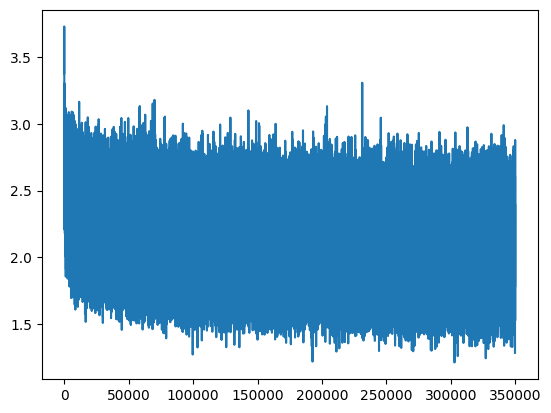

In [171]:
plt.plot(steps, losses)

### E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?